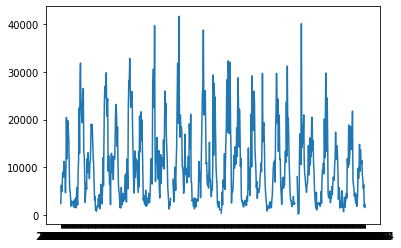

test개수:  77
Epoch 1/200
512/512 [==============================] - 5s 10ms/step - loss: 0.0477
Epoch 2/200
512/512 [==============================] - 3s 5ms/step - loss: 0.0368
Epoch 3/200
512/512 [==============================] - 2s 5ms/step - loss: 0.0363
Epoch 4/200
512/512 [==============================] - 2s 5ms/step - loss: 0.0355
Epoch 5/200
512/512 [==============================] - 2s 5ms/step - loss: 0.0352
Epoch 6/200
512/512 [==============================] - 3s 5ms/step - loss: 0.0336
Epoch 7/200
512/512 [==============================] - 3s 5ms/step - loss: 0.0305
Epoch 8/200
512/512 [==============================] - 3s 5ms/step - loss: 0.0256
Epoch 9/200
512/512 [==============================] - 2s 5ms/step - loss: 0.0187
Epoch 10/200
512/512 [==============================] - 2s 5ms/step - loss: 0.0179
Epoch 11/200
512/512 [==============================] - 3s 5ms/step - loss: 0.0148
Epoch 12/200
512/512 [==============================] - 3s 5ms/step - loss: 0.0137


KeyboardInterrupt: 

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

weekfrom = 2
weekto = 33
week = weekto - weekfrom

df = pd.read_csv('seoulbigparkdata.csv', engine='python')
# print(df.head())

df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)#날짜 column생성
# print(df.head())

df = df.set_index('날짜') 
# print(df.head())
# df.plot()

split_date_last = '2016-12-17'
split_date_start = '2017-3-30'

train = df.loc[:split_date_last, ['일계']]
test = df.loc[split_date_start:, ['일계']]
# print(train.head())

train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

#*************************************주 단위 15년동안의 입장객수 경향************************************************
train2 = train.iloc[0:0]
traintmp2 = train
for i in range(int(len(train)/7)):
    traintmp = train['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2 = pd.concat([train2, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2 = test.iloc[0:0]
testtmp2 = test
for i in range(int(len(test)/7)):
    testtmp = test['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2 = pd.concat([test2, testtmp2[i*7+6:i*7+7]], axis=0)
# print(test2.head)

plt.plot(train2)
plt.show()

#***********************************************************************************************************************
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train2)
test_sc = sc.transform(test2)

# print(train_sc)

train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train2.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test2.index)
# print(train_sc_df.head())

for s in range(weekfrom, weekto):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]
# print(X_train.head())
# print(y_train.head())

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

# print(X_train.head())

X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], week, 1)
X_test_t = X_test.reshape(X_test.shape[0], week, 1)

# print(X_test_t.shape)
print('test개수: ', len(y_test))

from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
from keras import optimizers
K.clear_session()
model = Sequential() # Sequeatial Model 
model.add(LSTM(60, input_shape=(week, 1), return_sequences = True)) # (timestep, feature)
model.add(LSTM(60))
model.add(Dense(1)) # output = 1 
adam = optimizers.Adam(lr=0.0004)
model.compile(loss='mean_squared_error', optimizer=adam) 
# print(model.summary())

early_stop = EarlyStopping(monitor='loss', patience=30, verbose=1)

model.fit(X_train_t, y_train, epochs=200,
          batch_size=10, verbose=1, callbacks=[early_stop])

# print("actual", y_test)

# print(type(y_test))
plt.plot(y_test)

y_pred = model.predict(X_test_t)
# print("predict", y_pred)

plt.plot(y_pred)
plt.show()